In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install fastbook
%pip install duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   

In [ ]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from fastdownload import download_url
from duckduckgo_search import DDGS
from PIL import Image
import numpy as np

In [ ]:
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [ ]:
ims = search_images('grizzly bear')
len(ims)

196

Download only one image of bear. And then open the image.

In [ ]:
dest = 'images/grizzly.jpg'
download_url(str(ims[0]), dest)

Path('images/grizzly.jpg')

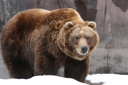

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

Download all bear images from downloaded urls.

In [ ]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
  path.mkdir()
  for i in bear_types:
    dest = (path/i)
    dest.mkdir(exist_ok=True)
    results = search_images(f'{i} bear')
    download_images(dest, urls=results)

In [ ]:
fns = get_image_files(path)

failed = verify_images(fns)

In [ ]:
failed.map(Path.unlink)

(#21) [None,None,None,None,None,None,None,None,None,None...]

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

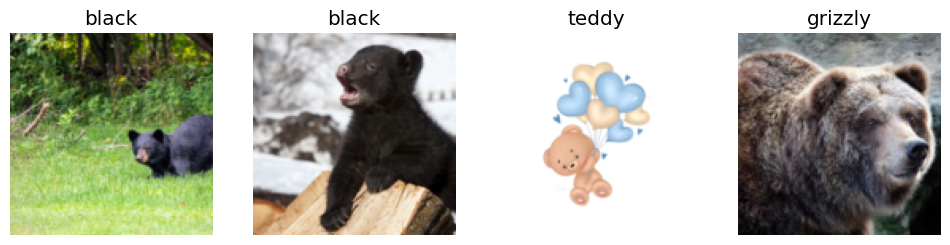

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

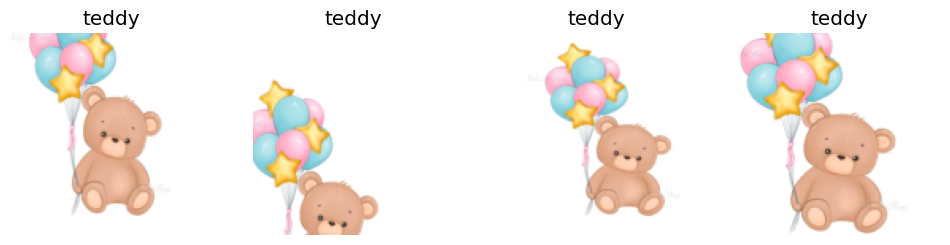

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

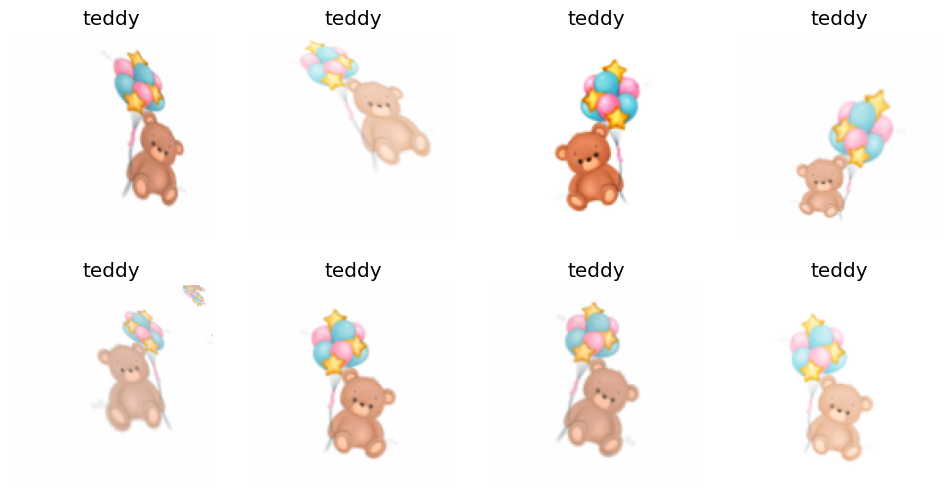

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Model training

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.128786,0.099919,0.022989,00:24


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.181175,0.083859,0.011494,00:21
1,0.134187,0.085412,0.011494,00:21
2,0.112754,0.099850,0.011494,00:21
3,0.094923,0.100752,0.011494,00:21


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


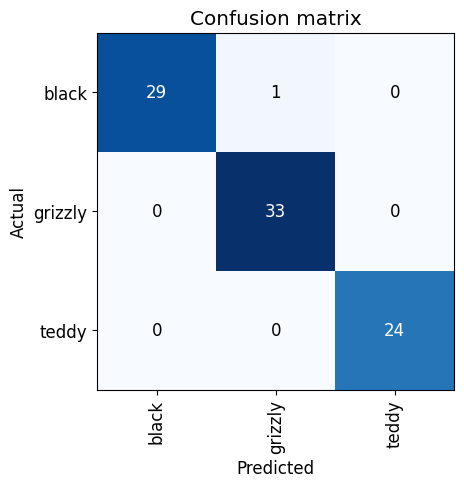

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

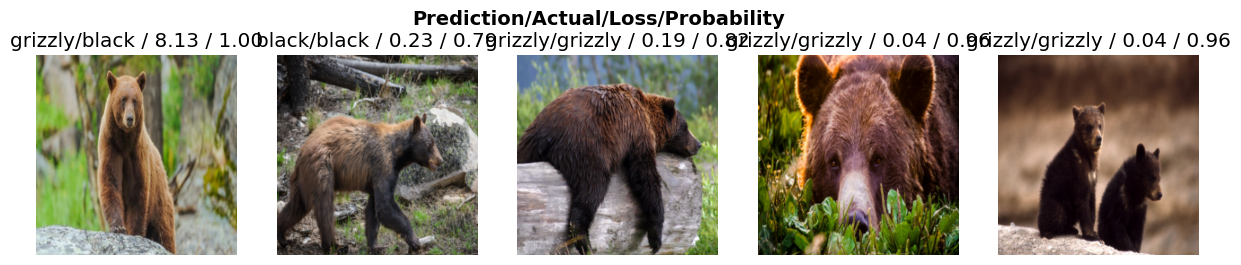

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
img = Image.open('/content/image_black.jpg')
img_array = np.array(img)

In [ ]:
pred, pred_idx, probs = learn.predict(img_array)
print(f"This is a: {pred}.")
print(f"Probability: {probs[0]:.04f}")

This is a: black.
Probability: 0.9994
